In [1]:
import sounddevice as sd
from scipy.io.wavfile import write, read
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Count number of ticks in the recording,
# assuming that each tick lasts less than 1000 samples
# (Interval of 0.1 seconds (10 Hz) is 4410 samples)
def count_ticks(sound, threshold):
    count = 0
    i = 0
    while i < len(sound):
        sample = sound[i]
        if sample > threshold:
            count += 1
            i += 1000
        else:
            i += 1
    return count

In [3]:
# Returns the index of the first peak
def find_first_peak(sound, threshold):
    peak_val = threshold
    max_i = None
    i = 0
    while i < len(sound):
        sample = sound[i]
        if sample > threshold:
            peak_val = max(sound[i:i+1000])
            return np.where(sound==peak_val)[0][0]
        else:
            i += 1
    return max_i

# Returns the index of the last peak
def find_last_peak(sound, threshold):
    i = len(sound) - 1
    max_i = None
    peak_val = threshold
    while i >= 1000:
        sample = sound[i]
        if sample > threshold:
            peak_val = max(sound[i-1000:i])
            return np.where(sound==peak_val)[0][0]
        else:
            i -= 1
    return max_i

In [4]:
def find_threshold(sound, target_freq=6):
    # Perform binary search on threshold until we get within 5% of target freq
    upper_thresh = 1
    lower_thresh = 0
    thresh = 0.5
    last_freq = -1
    trimmed = sound[find_first_peak(sound, thresh):find_last_peak(sound, thresh)]
    if len(trimmed)/fs <= 1:
        return 0
    stuck = 0
    while stuck < 3:
        freq = (count_ticks(trimmed, thresh) - 1) / (len(trimmed)/fs)
        if freq > target_freq:
            if abs(freq - target_freq) > abs(last_freq - target_freq):
                # If the previous answer was better, then return the previous answer
                return thresh * 2
            thresh = (thresh + upper_thresh) / 2
            lower_thresh = thresh
        elif freq <= target_freq:
            if abs(freq - target_freq) > abs(last_freq - target_freq):
                # If the previous answer was better, then return the previous answer
                return thresh / 2
            thresh = (lower_thresh + thresh) / 2
            upper_thresh = thresh
        # If we didn't make a progress, then increase stuck counter
        # Otherwise reset the stuck counter
        if abs(freq - last_freq) <= 0.0001:
            stuck += 1
        else:
            stuck = 0
        last_freq = freq
    return thresh

In [5]:
def get_beat_error(freq, target_freq=6):
    num_seconds_a_day = 24*60*60
    one_clock_incment = 1/target_freq
    num_clock_seconds_a_day = freq * num_seconds_a_day * one_clock_incment
    return num_clock_seconds_a_day - num_seconds_a_day

In [6]:
fs = 44100  # Sample rate
seconds = 5  # Duration of recording
num_samples = 3 # Number of recordings to average over
# Channel L = index 0
# Channel R = index 1

In [7]:
samples = []
for i in range(num_samples):
    print(f"Recording sample {i}")
    recording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
    sd.wait()
    recording = recording[fs:,1]
    samples.append(recording[find_first_peak(recording, find_threshold(recording)):])
print("Done :)")


Recording sample 0
Recording sample 1
Recording sample 2
Done :)


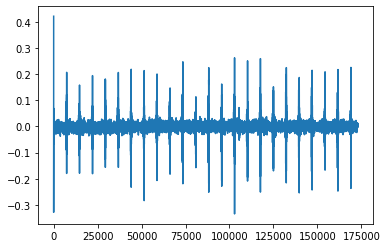

In [8]:
longest_size = len(max(samples, key=lambda x: len(x)))

for i in range(len(samples)):
    samples[i] = np.pad(samples[i], (0, longest_size - len(samples[i])))

avg_sample = np.average(samples, axis=0)
plt.figure()
plt.plot(avg_sample)
plt.show()

In [9]:
thresh = find_threshold(avg_sample)

In [10]:
thresh

0.0625

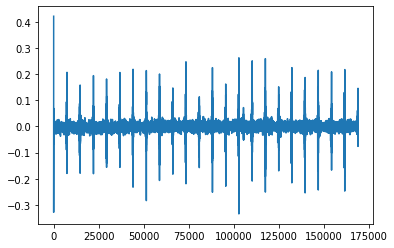

In [11]:
trimmed = avg_sample[find_first_peak(avg_sample, thresh):find_last_peak(avg_sample, thresh)]
plt.figure()
plt.plot(trimmed)
plt.show()

In [12]:
count_ticks(trimmed, thresh)

25

In [22]:
freq = (count_ticks(trimmed, thresh) - 1) / (len(trimmed)/fs)
freq

6.259795716795107

In [23]:
get_beat_error(freq)

3741.0583218495303

In [15]:
from scipy.fftpack import fft

In [16]:
watch_recording = trimmed
N = len(watch_recording)
T = 1/fs
time_stamp = np.linspace(0, N/fs, N)
yf = fft(watch_recording)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

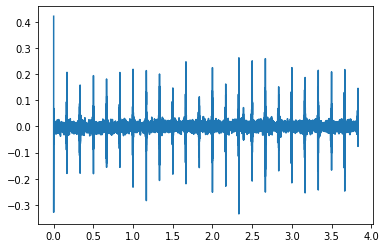

In [17]:
plt.figure()
plt.plot(time_stamp, watch_recording)
plt.show()

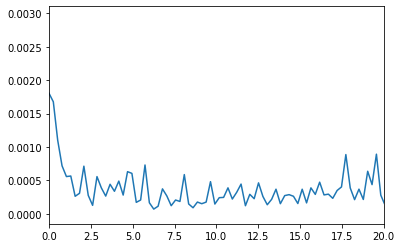

In [18]:
plt.figure()
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim(0, 20)
plt.show()

In [19]:
lower_i = 0
upper_i = 0
i = 0
while xf[i] < 6.3:
    if xf[i] < 5.7 and xf[i+1] >= 5.7:
        lower_i = i+1
    i += 1
upper_i = i

In [20]:
freq = xf[np.where(max((2.0/N * np.abs(yf[0:N//2]))[lower_i:upper_i]) == (2.0/N * np.abs(yf[0:N//2])))[0][0]]
freq

5.738247888523504

In [21]:
get_beat_error(freq)

-3769.230405261551